In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)

import numpy as np
np.random.seed = 42

# Categorical nuisance

In [77]:
from carl.distributions import Mixture, MultivariateNormal

p = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.eye(2))
q0 = MultivariateNormal(mu=np.array([1., 0]), sigma=np.eye(2))
q1 = MultivariateNormal(mu=np.array([1, 0.+1]), sigma=np.eye(2))
q2 = MultivariateNormal(mu=np.array([1, 0.+2]), sigma=np.eye(2))
q_full = Mixture(components=[q0, q1, q2])

In [78]:
from keras.utils import np_utils

n_samples = 50000
n_samples //= (2 * 3)

X0 = np.vstack([p.rvs(n_samples), 
                q0.rvs(n_samples)])
y0 = np.zeros(len(X0))
y0[len(X0) // 2:] = 1

X1 = np.vstack([p.rvs(n_samples), 
                q1.rvs(n_samples)])
y1 = np.zeros(len(X1))
y1[len(X1) // 2:] = 1

X2 = np.vstack([p.rvs(n_samples), 
                q2.rvs(n_samples)])
y2 = np.zeros(len(X2))
y2[len(X2) // 2:] = 1

X = np.vstack([X0, X1, X2])
y = np.concatenate([y0, y1, y2])

z = np.zeros(len(X))
z[len(X0):] = 1
z[2*len(X0):] = 2
z = np_utils.to_categorical(z.astype(np.int))

In [79]:
X.shape, y.shape, z.shape

((49998, 2), (49998,), (49998, 3))

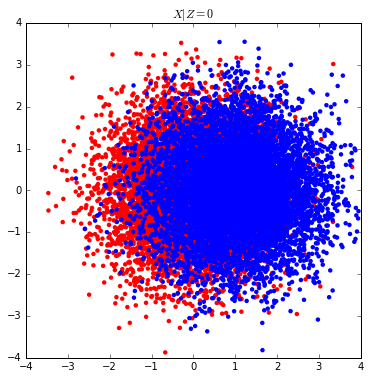

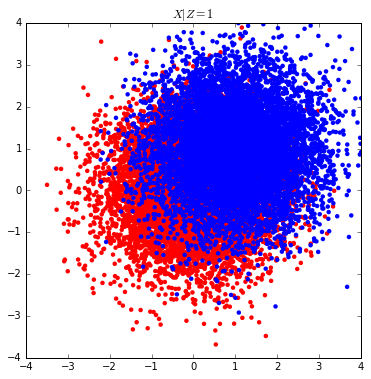

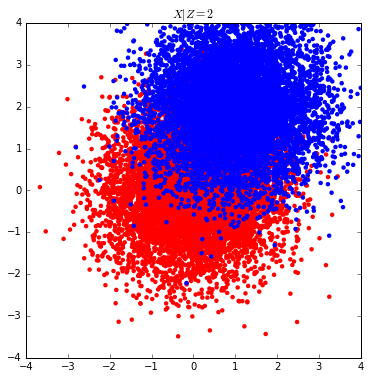

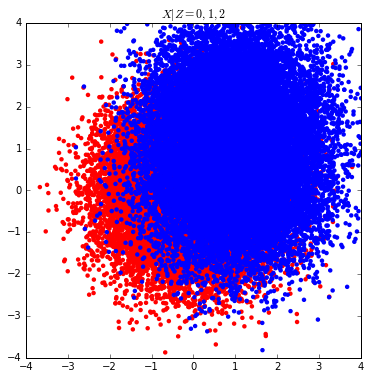

In [80]:
plt.title("$X|Z=0$")
plt.scatter(X0[y0==0, 0], X0[y0==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X0[y0==1, 0], X0[y0==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=1$")
plt.scatter(X1[y1==0, 0], X1[y1==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X1[y1==1, 0], X1[y1==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=2$")
plt.scatter(X2[y2==0, 0], X2[y2==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X2[y2==1, 0], X2[y2==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.title("$X|Z=0,1,2$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [81]:
from scipy.stats import entropy

# when Z is marginalized out, the best classifier is p.pdf(X) / (p.pdf(X) + q_full.pdf(X)

probas = p.pdf(X) / (p.pdf(X) + q_full.pdf(X))
probas = np.hstack([probas.reshape(-1, 1), 
                    (1.-probas).reshape(-1, 1)])
min_Lf = np.mean([entropy(p_i) for p_i in probas])   # lower bound on Lf
min_Lr = entropy([1. / 3] * 3)

In [82]:
min_Lf, min_Lr

(0.5036663952314574, 1.0986122886681096)

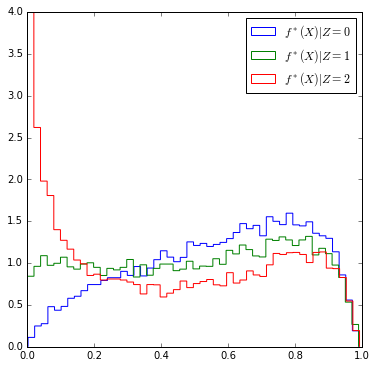

In [83]:
# best model trained on union
d = p.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=0$", normed=1)
d = p.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=1$", normed=1)
d = p.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))
plt.hist(d, bins=50, histtype="step", label="$f^*(X)|Z=2$", normed=1)
plt.legend(loc="best")
#plt.ylim(0, 4.)
plt.show()

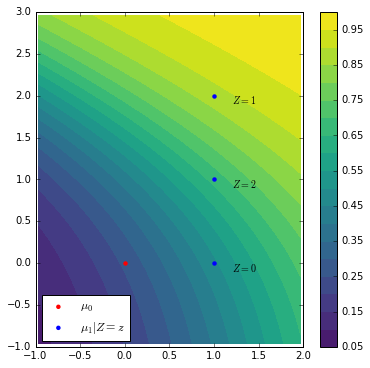

In [106]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 3. 
X_test[:, 0] -= 1.
X_test[:, 1] *= 4. 
X_test[:, 1] -= 1.

y_pred = q_full.pdf(X_test) / (p.pdf(X_test) + q_full.pdf(X_test))

xi = np.linspace(-1., 2., 100)
yi = np.linspace(-1., 3, 100)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0+1], c="blue", linewidths=0)
plt.scatter([1], [0+2], c="blue", linewidths=0)
plt.text(1.2, 0-0.1, "$Z=0$", color="k")
plt.text(1.2, 1-0.1, "$Z=2$", color="k")
plt.text(1.2, 2-0.1, "$Z=1$", color="k")
plt.xlim(-1,2)
plt.ylim(-1,3)
plt.legend(loc="lower left", scatterpoints=1)
plt.show()

In [107]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, q_full.pdf(X0) / (p.pdf(X0) + q_full.pdf(X0))), 
 roc_auc_score(y1, q_full.pdf(X1) / (p.pdf(X1) + q_full.pdf(X1))),
 roc_auc_score(y1, q_full.pdf(X2) / (p.pdf(X2) + q_full.pdf(X2))),
 roc_auc_score(y, q_full.pdf(X) / (p.pdf(X) + q_full.pdf(X))))

(0.7269202060534119,
 0.83569742885719267,
 0.93088708547741883,
 0.83116566232312084)

# Adversarial training of f

In [119]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=5000)

In [120]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(z.shape[1], activation="softmax")(Rx)
R = Model(input=[inputs], output=[Rx])

In [121]:
from keras.optimizers import SGD
import keras.backend as K

lam = 10.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        return c * K.categorical_crossentropy(z_pred, z_true)
    return loss_R

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0) 
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(c=-lam)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0) 
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=1.0)], 
            optimizer=opt_DfR)

In [122]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_15 (Model)                 (None, 1)             501         input_5[0][0]                    
____________________________________________________________________________________________________
model_16 (Model)                 (None, 3)             1024        input_5[0][0]                    
Total params: 1525
____________________________________________________________________________________________________


In [123]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
model_16 (Model)                 (None, 3)             1024        input_5[0][0]                    
Total params: 1024
____________________________________________________________________________________________________


In [124]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train, y_train, nb_epoch=10)

Epoch 1/10
44998/44998 [==============================] - 1s - loss: 0.5381     
Epoch 2/10
44998/44998 [==============================] - 1s - loss: 0.5073     
Epoch 3/10
44998/44998 [==============================] - 1s - loss: 0.5057     
Epoch 4/10
44998/44998 [==============================] - 1s - loss: 0.5051     
Epoch 5/10
44998/44998 [==============================] - 1s - loss: 0.5047     
Epoch 6/10
44998/44998 [==============================] - 1s - loss: 0.5044     
Epoch 7/10
44998/44998 [==============================] - 1s - loss: 0.5042     
Epoch 8/10
44998/44998 [==============================] - 1s - loss: 0.5039     
Epoch 9/10
44998/44998 [==============================] - 1s - loss: 0.5038     
Epoch 10/10
44998/44998 [==============================] - 1s - loss: 0.5035     


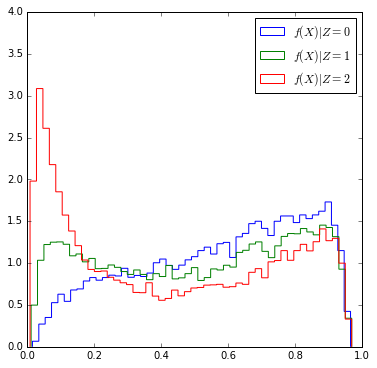

In [125]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="$f(X)|Z=0$")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="$f(X)|Z=1$")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="$f(X)|Z=2$")
plt.legend(loc="best")
plt.ylim(0, 4.)
plt.show()

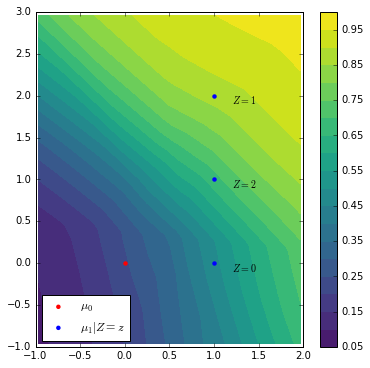

In [127]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 3. 
X_test[:, 0] -= 1.
X_test[:, 1] *= 4. 
X_test[:, 1] -= 1.

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-1., 2., 100)
yi = np.linspace(-1., 3, 100)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0+1], c="blue", linewidths=0)
plt.scatter([1], [0+2], c="blue", linewidths=0)
plt.text(1.2, 0-0.1, "$Z=0$", color="k")
plt.text(1.2, 1-0.1, "$Z=2$", color="k")
plt.text(1.2, 2-0.1, "$Z=1$", color="k")
plt.xlim(-1,2)
plt.ylim(-1,3)
plt.legend(loc="lower left", scatterpoints=1)
plt.show()

In [128]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, nb_epoch=10)

Epoch 1/10
44998/44998 [==============================] - 1s - loss: 1.0921     
Epoch 2/10
44998/44998 [==============================] - 1s - loss: 1.0801     
Epoch 3/10
44998/44998 [==============================] - 2s - loss: 1.0737     
Epoch 4/10
44998/44998 [==============================] - 1s - loss: 1.0697     
Epoch 5/10
44998/44998 [==============================] - 1s - loss: 1.0668     
Epoch 6/10
44998/44998 [==============================] - 1s - loss: 1.0646     
Epoch 7/10
44998/44998 [==============================] - 1s - loss: 1.0631     
Epoch 8/10
44998/44998 [==============================] - 1s - loss: 1.0621     
Epoch 9/10
44998/44998 [==============================] - 2s - loss: 1.0613     
Epoch 10/10
44998/44998 [==============================] - 1s - loss: 1.0606     


In [129]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    plt.axhline(y=min_Lf, ls="dashed")
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    plt.axhline(y=min_Lr, ls="dashed")
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    plt.axhline(y=min_Lf - lam*min_Lr, ls="dashed")
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    plt.show()   

In [130]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

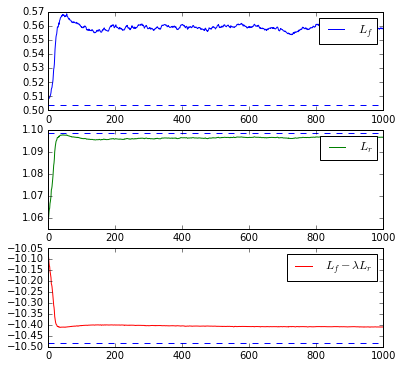

In [131]:
batch_size = 128

for i in range(1001):
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    if i % 50 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
    for j in range(100):
        indices = np.random.permutation(len(X_train))[:batch_size]
        DfR.train_on_batch(X_train[indices], z_train[indices])

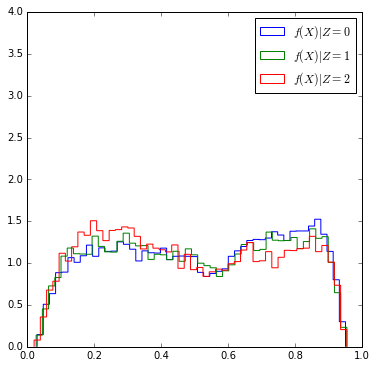

In [132]:
plt.hist(1. - D.predict(X0), bins=50, normed=1, histtype="step", label="$f(X)|Z=0$")
plt.hist(1. - D.predict(X1), bins=50, normed=1, histtype="step", label="$f(X)|Z=1$")
plt.hist(1. - D.predict(X2), bins=50, normed=1, histtype="step", label="$f(X)|Z=2$")
plt.legend(loc="best")
plt.ylim(0, 4.)
plt.show()

Looks pivotal!

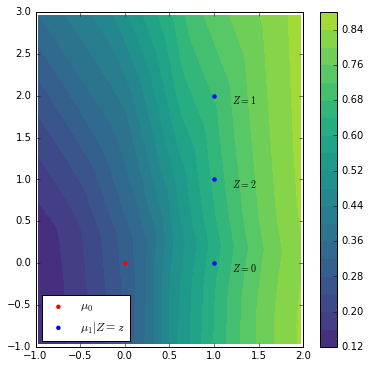

In [133]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 3. 
X_test[:, 0] -= 1.
X_test[:, 1] *= 4. 
X_test[:, 1] -= 1.

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-1., 2., 100)
yi = np.linspace(-1., 3, 100)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0+1], c="blue", linewidths=0)
plt.scatter([1], [0+2], c="blue", linewidths=0)
plt.text(1.2, 0-0.1, "$Z=0$", color="k")
plt.text(1.2, 1-0.1, "$Z=2$", color="k")
plt.text(1.2, 2-0.1, "$Z=1$", color="k")
plt.xlim(-1,2)
plt.ylim(-1,3)
plt.legend(loc="lower left", scatterpoints=1)
plt.show()

In [134]:
from sklearn.metrics import roc_auc_score
(roc_auc_score(y0, D.predict(X0)), 
 roc_auc_score(y1, D.predict(X1)), 
 roc_auc_score(y2, D.predict(X2)), 
 roc_auc_score(y, D.predict(X)))

(0.75786104527104414,
 0.78782848901859603,
 0.82531621437664426,
 0.79043020595178781)

In [135]:
print(min_Lr)

probas = DfR.predict(X_valid)
mean_entropy_f = np.mean([entropy(q) for q in probas])
print(mean_entropy_f)

1.09861228867
1.09719


---

# Continuous nuisance

In [219]:
np.random.seed = 777
from carl.distributions import Mixture, MultivariateNormal, Uniform

p0 = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.array([[1., -0.5], [-0.5, 1.]]))
p1 = MultivariateNormal(mu=np.array([1., 0.]), sigma=np.eye(2))
pz = Uniform(low=0, high=2.0)

In [220]:
n_samples = 50000

X0 = p0.rvs(n_samples // 2)
X1 = p1.rvs(n_samples // 2)
z = pz.rvs(n_samples).ravel()
X1[:, 1] += z[n_samples // 2:]

X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1

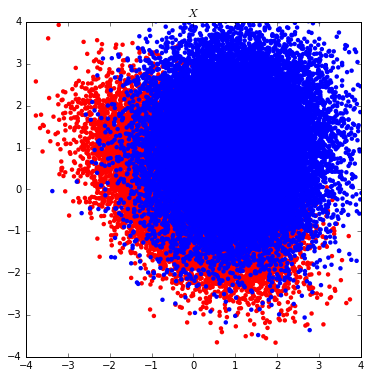

In [221]:
plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

# Adversarial training of f

In [222]:
from sklearn.cross_validation import train_test_split

X_train, X_valid, y_train, y_valid, z_train, z_valid = train_test_split(X, y, z, test_size=5000)

In [223]:
import keras.backend as K
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(20, activation="tanh")(inputs)
Dx = Dense(20, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

a, b = 0, 2
n_components = 4
Rx = D(inputs)
Rx = Dense(20, activation="relu")(Rx)
Rx = Dense(20, activation="relu")(Rx)
mu = Dense(n_components, activation="tanh")(Rx)
mu = Lambda(lambda x: (x+1.0)/2.0 * (b-a) + a)(mu)
sigma = Dense(n_components, activation=K.exp)(Rx)
pi = Dense(n_components, activation="softmax")(Rx)
Rx = Merge(mode="concat")([mu, sigma, pi])

R = Model(input=[inputs], output=[Rx])

In [224]:
from keras.optimizers import SGD
import keras.backend as K
import theano.tensor as T

lam = 50.0

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        return c * K.binary_crossentropy(y_pred, y_true)
    return loss_D

def make_loss_R(lam, n_components, a, b):
    def loss(y_true, y_pred):
        y_true = y_true.ravel()
        
        mu = y_pred[:, :n_components]
        sigma = y_pred[:, n_components:2*n_components]
        pi = y_pred[:, 2*n_components:]
        
        pdf = pi[:, 0] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, 0] *
                          K.exp(-(y_true - mu[:, 0]) ** 2 / (2. * sigma[:, 0] ** 2)))
        
        Fa = pi[:, 0] * 0.5 * (1. + T.erf((a - mu[:, 0]) / (sigma[:, 0] * np.sqrt(2.))))
        Fb = pi[:, 0] * 0.5 * (1. + T.erf((b - mu[:, 0]) / (sigma[:, 0] * np.sqrt(2.))))
        
        for c in range(1, n_components):
            pdf += pi[:, c] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, c] *
                               K.exp(-(y_true - mu[:, c]) ** 2 / (2. * sigma[:, c] ** 2)))
            
            Fa += pi[:, c] * 0.5 * (1. + T.erf((a - mu[:, c]) / (sigma[:, c] * np.sqrt(2.))))
            Fb += pi[:, c] * 0.5 * (1. + T.erf((b - mu[:, c]) / (sigma[:, c] * np.sqrt(2.))))
        
        nll = -K.log(pdf / (Fb - Fa))
        
        return lam * nll.mean()
    
    return loss

opt_D = SGD()
D.compile(loss=[make_loss_D(c=1.0)], optimizer=opt_D)

opt_DRf = SGD(momentum=0.0)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=1.0), 
                  make_loss_R(-lam, n_components, a, b)],   
            optimizer=opt_DRf)

opt_DfR = SGD(momentum=0.0)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(1.0, n_components, a, b)], 
            optimizer=opt_DfR)

In [225]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_57 (Model)                 (None, 1)             501         input_15[0][0]                   
____________________________________________________________________________________________________
model_58 (Model)                 (None, 12)            1213        input_15[0][0]                   
Total params: 1714
____________________________________________________________________________________________________


In [226]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_58 (Model)                 (None, 12)            1213        input_15[0][0]                   
Total params: 1213
____________________________________________________________________________________________________


In [227]:
# Pretraining of D
D.trainable = True
R.trainable = False
D.fit(X_train, y_train, nb_epoch=10)
min_Lf = D.evaluate(X_valid, y_valid)

Epoch 1/10
45000/45000 [==============================] - 0s - loss: 0.4763     
Epoch 2/10
45000/45000 [==============================] - 0s - loss: 0.4452     
Epoch 3/10
45000/45000 [==============================] - 0s - loss: 0.4434     
Epoch 4/10
45000/45000 [==============================] - 0s - loss: 0.4428     
Epoch 5/10
45000/45000 [==============================] - 0s - loss: 0.4423     
Epoch 6/10
45000/45000 [==============================] - 0s - loss: 0.4420     
Epoch 7/10
45000/45000 [==============================] - 0s - loss: 0.4417     
Epoch 8/10
45000/45000 [==============================] - 0s - loss: 0.4414     
Epoch 9/10
45000/45000 [==============================] - 0s - loss: 0.4413     
Epoch 10/10
4896/5000 [============================>.] - ETA: 0s

In [228]:
def make_X(n_samples, z):
    X0 = p0.rvs(n_samples // 2)
    X1 = p1.rvs(n_samples // 2)
    X1[:, 1] += z
    X = np.vstack([X0, X1])
    y = np.zeros(n_samples)
    y[n_samples // 2:] = 1
    return X

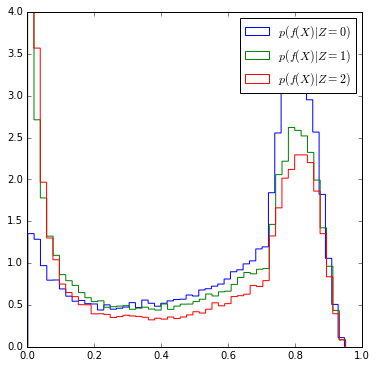

In [229]:
plt.hist(1. - D.predict(make_X(50000, z=0)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(1. - D.predict(make_X(50000, z=1)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=1)$")
plt.hist(1. - D.predict(make_X(50000, z=2)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=2)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.savefig("f-plain.pdf")
plt.show()

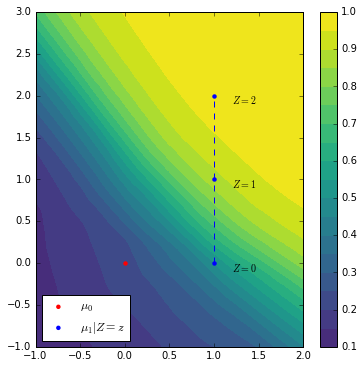

In [230]:
from matplotlib.mlab import griddata

X_test = np.random.rand(30000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-1., 2., 100)
yi = np.linspace(-1., 3, 100)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.vlines(1, 0, 2, color="blue", linestyles="dashed")
plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0+1], c="blue", linewidths=0)
plt.scatter([1], [0+2], c="blue", linewidths=0)
plt.text(1.2, 0-0.1, "$Z=0$", color="k")
plt.text(1.2, 1-0.1, "$Z=1$", color="k")
plt.text(1.2, 2-0.1, "$Z=2$", color="k")
plt.xlim(-1,2)
plt.ylim(-1,3)
plt.legend(loc="lower left", scatterpoints=1)
plt.savefig("surface-plain.pdf")
plt.show()

In [234]:
# Pretraining of R
D.trainable = False
R.trainable = True
DfR.fit(X_train, z_train, nb_epoch=10)

Epoch 1/10
45000/45000 [==============================] - 1s - loss: 0.6784     
Epoch 2/10
45000/45000 [==============================] - 1s - loss: 0.6779     
Epoch 3/10
45000/45000 [==============================] - 1s - loss: 0.6775     
Epoch 4/10
45000/45000 [==============================] - 1s - loss: 0.6772     
Epoch 5/10
45000/45000 [==============================] - 1s - loss: 0.6769     
Epoch 6/10
45000/45000 [==============================] - 1s - loss: 0.6766     
Epoch 7/10
45000/45000 [==============================] - 1s - loss: 0.6764     
Epoch 8/10
45000/45000 [==============================] - 1s - loss: 0.6762     
Epoch 9/10
45000/45000 [==============================] - 1s - loss: 0.6761     
Epoch 10/10
45000/45000 [==============================] - 1s - loss: 0.6759     


In [235]:
DfR.predict(X_train[:3])

array([[ 0.99419588,  0.39774823,  0.20744139,  0.60388637,  2.42896605,
         2.35470438,  1.57846773,  2.3629241 ,  0.17223909,  0.31528208,
         0.29334074,  0.21913812],
       [ 1.54618382,  0.43300164,  1.68630695,  1.34017324,  2.14560127,
         2.55140996,  0.68300146,  2.54856014,  0.1244626 ,  0.19277644,
         0.4776867 ,  0.20507425],
       [ 0.99959403,  0.40615445,  0.21072304,  0.60553306,  2.43192363,
         2.29424572,  1.57876813,  2.31958675,  0.17200664,  0.31349063,
         0.29272589,  0.22177686]], dtype=float32)

In [236]:
from IPython import display

min_Lr = np.log(2.0)

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    ax1 = plt.subplot(311)   
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")
    plt.legend(loc="upper right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.legend(loc="upper right")
    
    ax3 = plt.subplot(313, sharex=ax1)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.legend(loc="upper right")
    
    plt.show()  

In [237]:
losses = {"L_f": [], "L_r": [], "L_f - L_r": []}

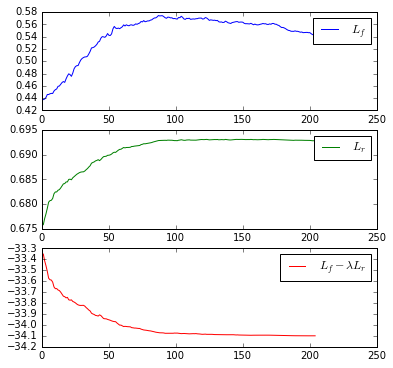

KeyboardInterrupt: 

In [241]:
batch_size = 128

for i in range(301):
    l = DRf.evaluate(X_valid, [y_valid, z_valid], verbose=0)    
    losses["L_f - L_r"].append(l[0][None][0])
    losses["L_f"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    if i % 5 == 0:
        plot_losses(i, losses)

    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X_train))[:batch_size]
    DRf.train_on_batch(X_train[indices], [y_train[indices], z_train[indices]])
        
    # Fit R
    D.trainable = False
    R.trainable = True

    for j in range(100):
        indices = np.random.permutation(len(X_train))
        DfR.train_on_batch(X_train[indices], z_train[indices])

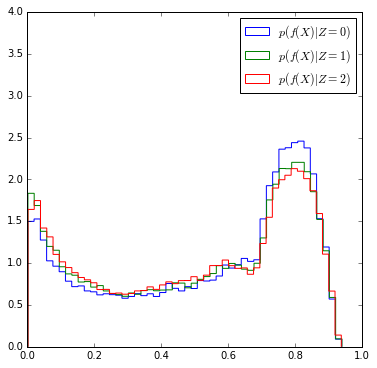

In [242]:
plt.hist(1. - D.predict(make_X(50000, z=0)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=0)$")
plt.hist(1. - D.predict(make_X(50000, z=1)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=1)$")
plt.hist(1. - D.predict(make_X(50000, z=2)), bins=50, normed=1, histtype="step", label="$p(f(X)|Z=2)$")
plt.legend(loc="best")
plt.ylim(0,4)
plt.savefig("f-adversary.pdf")
plt.show()

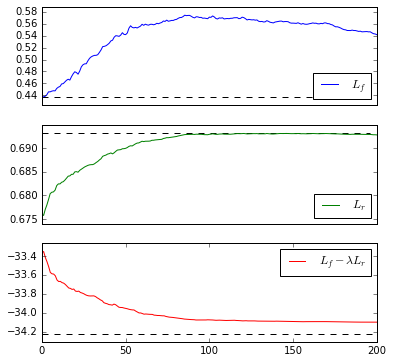

In [243]:
def plot_losses_final(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    n_iter = 200 #len(np.array(losses["L_f"]))-1

    ax1 = plt.subplot(311)  
    values = np.array(losses["L_f"])
    plt.plot(range(len(values)), values, label=r"$L_f$", color="blue")   
    plt.hlines(min_Lf, 0, n_iter, linestyles="dashed")
    low = min(min_Lf, values.min())
    high = max(min_Lf, values.max())
    #high = high - (high-low) * 0.3
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xticks([])
    plt.xlim(0, n_iter)
    plt.legend(loc="lower right")
    
    ax2 = plt.subplot(312, sharex=ax1) 
    values = np.array(losses["L_r"]) / lam
    plt.plot(range(len(values)), values, label=r"$L_r$", color="green")
    plt.hlines(min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lr, values.min())
    high = max(min_Lr, values.max())
    #high = high - (high-low) * 0.1
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.legend(loc="lower right")
    
    ax3 = plt.subplot(313)
    values = np.array(losses["L_f - L_r"])
    plt.plot(range(len(values)), values, label=r"$L_f - \lambda L_r$", color="red")  
    plt.hlines(min_Lf - lam*min_Lr, 0, n_iter, linestyles="dashed")
    low = min(min_Lf - lam*min_Lr, values.min())
    high = max(min_Lf - lam*min_Lr, values.max())
    #low = low + (high-low) * 0.5
    low, high = low - (high-low)*0.1, high + (high-low)*0.1
    plt.ylim(low, high)
    plt.xlim(0, n_iter)
    plt.legend(loc="upper right")
    
    plt.savefig("training.pdf")
    
    plt.show()  
    
plot_losses_final(losses)

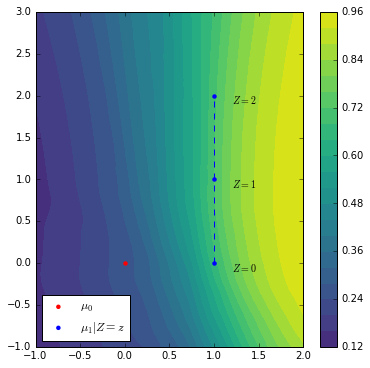

In [244]:
from matplotlib.mlab import griddata

X_test = np.random.rand(25000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 10. 
X_test[:, 1] -= 5.

y_pred = D.predict(X_test).ravel()

xi = np.linspace(-1., 2., 100)
yi = np.linspace(-1., 3, 100)
zi = griddata(X_test[:, 0], X_test[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis,
                  vmax=1.0, vmin=0.0)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mu_0$")
plt.vlines(1, 0, 2, color="blue", linestyles="dashed")
plt.scatter([1], [0], c="blue", linewidths=0, label=r"$\mu_1|Z=z$")
plt.scatter([1], [0+1], c="blue", linewidths=0)
plt.scatter([1], [0+2], c="blue", linewidths=0)
plt.text(1.2, 0-0.1, "$Z=0$", color="k")
plt.text(1.2, 1-0.1, "$Z=1$", color="k")
plt.text(1.2, 2-0.1, "$Z=2$", color="k")
plt.xlim(-1,2)
plt.ylim(-1,3)
plt.legend(loc="lower left", scatterpoints=1)
plt.savefig("surface-adversary.pdf")
plt.show()